In [1]:
from torchvision.datasets import VOCSegmentation
from lavis.models import load_model_and_preprocess

In [ ]:
load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True)

In [1]:
from diffusers import StableDiffusionPipeline

In [2]:
pipe = StableDiffusionPipeline.from_pretrained("/vinai/truongvt/checkpoints/stable-diffusion-2-1-base/")
pipe = pipe.to("cuda:4")

/home/ubuntu/.conda/envs/diff/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [3]:
image = pipe("A picture of a lion").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [1]:
from src.model.pipeline_stable_diffusion_with_attention import StableDiffusionPipelineWithAttention

pipe = StableDiffusionPipelineWithAttention.from_pretrained("/vinai/truongvt/checkpoints/stable-diffusion-2-1-base/")
pipe = pipe.to("cuda:4")

image = pipe(["A picture of a lion", "A picture of a cat"]).images

/home/ubuntu/.conda/envs/diff/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

5 torch.Size([20, 4096, 4096])
5 torch.Size([20, 4096, 77])
5 torch.Size([20, 4096, 4096])
5 torch.Size([20, 4096, 77])
10 torch.Size([40, 1024, 1024])
10 torch.Size([40, 1024, 77])
10 torch.Size([40, 1024, 1024])
10 torch.Size([40, 1024, 77])
20 torch.Size([80, 256, 256])
20 torch.Size([80, 256, 77])
20 torch.Size([80, 256, 256])
20 torch.Size([80, 256, 77])
20 torch.Size([80, 64, 64])
20 torch.Size([80, 64, 77])
20 torch.Size([80, 256, 256])
20 torch.Size([80, 256, 77])
20 torch.Size([80, 256, 256])
20 torch.Size([80, 256, 77])
20 torch.Size([80, 256, 256])
20 torch.Size([80, 256, 77])
10 torch.Size([40, 1024, 1024])
10 torch.Size([40, 1024, 77])
10 torch.Size([40, 1024, 1024])
10 torch.Size([40, 1024, 77])
10 torch.Size([40, 1024, 1024])
10 torch.Size([40, 1024, 77])
5 torch.Size([20, 4096, 4096])
5 torch.Size([20, 4096, 77])
5 torch.Size([20, 4096, 4096])
5 torch.Size([20, 4096, 77])
5 torch.Size([20, 4096, 4096])
5 torch.Size([20, 4096, 77])
5 torch.Size([20, 4096, 4096])
5 torch.

In [3]:
for i in pipe.attention_store.global_store['mid_cross']:
    print(i.shape)
for i in pipe.attention_store.global_store['up_cross']:
    print(i.shape)
for i in pipe.attention_store.global_store['down_cross']:
    print(i.shape)

torch.Size([2, 8, 8, 77])
torch.Size([2, 16, 16, 77])
torch.Size([2, 16, 16, 77])
torch.Size([2, 16, 16, 77])
torch.Size([2, 32, 32, 77])
torch.Size([2, 32, 32, 77])
torch.Size([2, 32, 32, 77])
torch.Size([2, 64, 64, 77])
torch.Size([2, 64, 64, 77])
torch.Size([2, 64, 64, 77])
torch.Size([2, 64, 64, 77])
torch.Size([2, 64, 64, 77])
torch.Size([2, 32, 32, 77])
torch.Size([2, 32, 32, 77])
torch.Size([2, 16, 16, 77])
torch.Size([2, 16, 16, 77])


In [2]:
from src.model.utils import ensemble_normalized_cross_attention

In [4]:
out = ensemble_normalized_cross_attention(attention_store=pipe.attention_store, res=512, from_where=[], select=1, token_indices=[1])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 out = ensemble_normalized_cross_attention(attention_store=pipe.attention_store, res=512,     │
│   2                                                                                              │
│                                                                                                  │
│ /home/ubuntu/dataset-diffusion/src/model/utils.py:26 in ensemble_normalized_cross_attention      │
│                                                                                                  │
│   23 │   for k, attention_map in attention_maps.items():                                         │
│   24 │   │   list_cross_attention    = []               #   Use to store resized cross attent    │
│   25 │   │   for index in token_indices:                                                         │
│ ❱ 26 │   │   │   token_attention     = attention_map[:, :, :, index]                             │
│   27 │   │   │   resolution = attention_map.shape[1]                                             │
│   28 │   │   │                                                                                   │
│   29 │   │   │   if resolution < max_resolution:                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: list indices must be integers or slices, not tuple

In [5]:
attention_maps = pipe.attention_store.get_average_attention()

In [11]:
for k, attention_map_list in attention_maps.items():
    list_cross_attention    = []               #   Use to store resized cross attention map (resize to the max resolution)
    for attention_map in attention_map_list:
        print(attention_map[:, :, :, [1, 2]].shape)
        break

torch.Size([2, 64, 64, 2])
torch.Size([2, 8, 8, 2])
torch.Size([2, 16, 16, 2])
torch.Size([2, 64, 64, 2])
torch.Size([2, 8, 8, 2])
torch.Size([2, 16, 16, 2])


In [12]:
import torch
import torch.nn.functional as F

In [18]:
max_resolution  = 512
# img_size        = 512
attention_store_res = dict()
#   Get the attention maps of each token at different scale

for k, attention_map_list in attention_maps.items():
    list_cross_attention    = []               #   Use to store resized cross attention map (resize to the max resolution)
    for attention_map in attention_map_list:
        token_attention = attention_map[:, :, :, [1]]
        token_attention /= token_attention.max()
        resolution = attention_map.shape[1]

        if resolution < max_resolution:
            token_attention = F.interpolate(token_attention.permute(0, 3, 1, 2), size=max_resolution, mode = 'bilinear').permute(0, 2, 3, 1)

        list_cross_attention.append(token_attention)     

        attention_store_res[k] = torch.stack(list_cross_attention, dim=0).mean(dim=0)

/home/ubuntu/.conda/envs/diff/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [23]:
average_attention_map = (attention_store_res['down_cross'] + \
        attention_store_res['mid_cross'] + attention_store_res['up_cross']) / 3

In [26]:
average_attention_map.mean(dim=-1).shape

torch.Size([2, 512, 512])

In [27]:
a = torch.randn(2, 3, 4, 5)

In [28]:
a[[0, 1], :, :, [2, 4]]

tensor([[[-0.0356, -1.1503, -0.5277, -0.2557],
         [ 0.1177, -1.4333,  0.8229,  0.6891],
         [-0.1760,  1.0070,  2.0727,  1.3225]],

        [[-0.5435,  0.1960, -0.0052, -0.1639],
         [-0.3407,  0.4894,  0.6359, -1.3427],
         [-1.6027, -0.2133, -0.1636,  1.5589]]])

In [34]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [36]:
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error Tunnel connection
[nltk_data]     failed: 403 VG-Blockpage>


False

In [316]:
import numpy as np
from typing import List
import cv2
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
import torch
import torch.nn.functional as F

MAX_ITER = 10
POS_W = 3
POS_XY_STD = 1
Bi_W = 4
Bi_XY_STD = 67
Bi_RGB_STD = 3

def get_token_indices_from_classes(classes, prompts):
    indices, class_labels = [], []
    classes_syn = {}

    for class_id, word in enumerate(classes):
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                classes_syn.update({lemma.name(): class_id})

    lemmatizer = WordNetLemmatizer()
    for prompt in prompts:
        prompt = prompt.replace("woman", "person").replace("man", "person").replace("women", "person").replace("men", "person").replace("people", "person")
        tokens = word_tokenize(prompt)
        normalized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
        for i, token in enumerate(normalized_tokens):
            if token in classes_syn:
                indices.append(i+1)
                class_labels.append(classes_syn[token])
                break
        if i == len(normalized_tokens) - 1:
            indices.append(-1)
    return np.array(indices), np.array(class_labels)


def ensemble_normalized_cross_attention(attention_store,
                                        token_indices: List[int]):
    """
    A_{s, j} = 1/(S*T) * \sum (A_{s,t} / max(A_{s,t}))
    """
    
    max_resolution  = 512
    attention_store_res = dict()
    #   Get the attention maps of each token at different scale
    attention_maps = attention_store.get_average_attention()

    list_cross_attention    = []               #   Use to store resized cross attention map (resize to the max resolution)
    for k, attention_map_list in attention_maps.items():
        for attention_map in attention_map_list:
            token_attention = attention_map[range(len(attention_map)), :, :, token_indices]
            token_attention /= token_attention.max()
            resolution = attention_map.shape[1]
            
            if resolution < max_resolution:
                token_attention = F.interpolate(token_attention.unsqueeze(1), size=max_resolution, mode='bilinear', align_corners=True).squeeze(dim=1)

            list_cross_attention.append(token_attention)     
    average_attention_map = torch.stack(list_cross_attention, dim=0).mean(dim=0)

    # average_attention_map = (attention_store_res['down_cross'] + \
    #     attention_store_res['mid_cross'] + attention_store_res['up_cross']) / 3

    #   Ensemble
    return average_attention_map


def dense_crf(image: np.array, attention: np.array, threshold: float):
    image = np.ascontiguousarray(image)

    labels = (attention > threshold).astype(int)
    
    c = 2
    h = labels.shape[0]
    w = labels.shape[1]

    U = utils.unary_from_labels(labels, 2, 0.7, zero_unsure=False)
    U = np.ascontiguousarray(U)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=image, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q

In [61]:
import mmengine

data = mmengine.load("voc_captions.json")
prompts = [prompt['caption'] for prompt in data]

In [324]:
classes=('aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
    'sofa', 'train', 'tvmonitor')

indices, labels = get_token_indices_from_classes(classes, prompts[1:2])
valid = (indices > -1)
used_prompts = prompts[1:2]

In [325]:
out = pipe(used_prompts)

  0%|          | 0/50 [00:00<?, ?it/s]

5 torch.Size([10, 4096, 4096])
5 torch.Size([10, 4096, 77])
5 torch.Size([10, 4096, 4096])
5 torch.Size([10, 4096, 77])
10 torch.Size([20, 1024, 1024])
10 torch.Size([20, 1024, 77])
10 torch.Size([20, 1024, 1024])
10 torch.Size([20, 1024, 77])
20 torch.Size([40, 256, 256])
20 torch.Size([40, 256, 77])
20 torch.Size([40, 256, 256])
20 torch.Size([40, 256, 77])
20 torch.Size([40, 64, 64])
20 torch.Size([40, 64, 77])
20 torch.Size([40, 256, 256])
20 torch.Size([40, 256, 77])
20 torch.Size([40, 256, 256])
20 torch.Size([40, 256, 77])
20 torch.Size([40, 256, 256])
20 torch.Size([40, 256, 77])
10 torch.Size([20, 1024, 1024])
10 torch.Size([20, 1024, 77])
10 torch.Size([20, 1024, 1024])
10 torch.Size([20, 1024, 77])
10 torch.Size([20, 1024, 1024])
10 torch.Size([20, 1024, 77])
5 torch.Size([10, 4096, 4096])
5 torch.Size([10, 4096, 77])
5 torch.Size([10, 4096, 4096])
5 torch.Size([10, 4096, 77])
5 torch.Size([10, 4096, 4096])
5 torch.Size([10, 4096, 77])
5 torch.Size([10, 4096, 4096])
5 torch.

In [326]:
attentions = ensemble_normalized_cross_attention(pipe.attention_store, indices)
attentions = attentions.cpu().numpy()

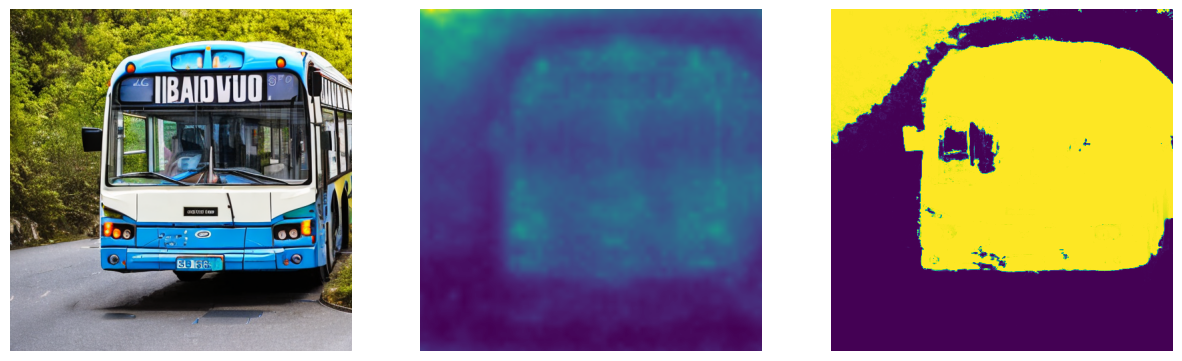

In [332]:
import matplotlib.pyplot as plt 
%matplotlib inline

for image, attention in zip(out.images, attentions):
    out_crf = dense_crf(np.array(image), attention, 0.23)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].axis("off")
    axs[1].imshow(attention)
    axs[1].axis("off")
    axs[2].imshow(out_crf[1])
    axs[2].axis("off")
    plt.show()

In [258]:
attentions[0]

array([[0.16079715, 0.16079715, 0.16079715, ..., 0.22145079, 0.22145079,
        0.22145079],
       [0.16079715, 0.16079715, 0.16079715, ..., 0.22145079, 0.22145079,
        0.22145079],
       [0.16079715, 0.16079715, 0.16079715, ..., 0.22145079, 0.22145079,
        0.22145079],
       ...,
       [0.17335743, 0.17335743, 0.17335743, ..., 0.20207612, 0.20207612,
        0.20207612],
       [0.17335743, 0.17335743, 0.17335743, ..., 0.20207612, 0.20207612,
        0.20207612],
       [0.17335743, 0.17335743, 0.17335743, ..., 0.20207612, 0.20207612,
        0.20207612]], dtype=float32)

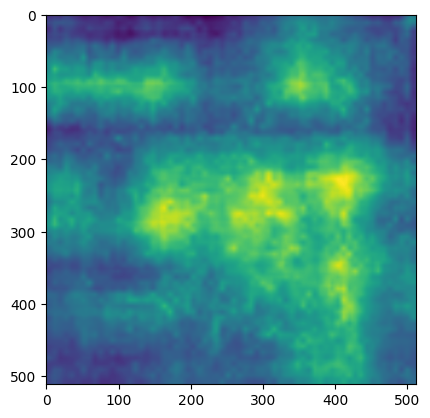

In [246]:
plt.imshow(attention.cpu().numpy())

In [136]:
img = np.array(out.images[0])

In [139]:
labels

array([17])

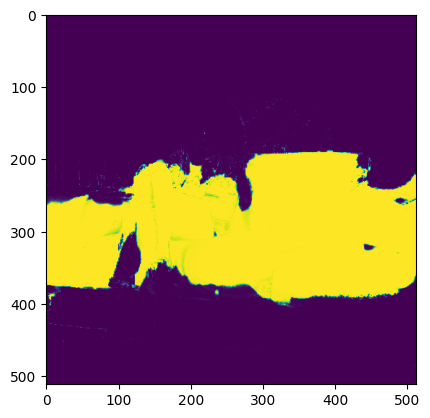

In [203]:
plt.imshow(out_crf[1])

In [53]:
import nltk
from nltk.corpus import wordnet

word = "person"
synonyms = []

for syn in wordnet.synsets(word):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())

print(set(synonyms))

{'mortal', 'soul', 'somebody', 'someone', 'individual', 'person'}


In [8]:
import mmcv, cv2

img = mmcv.imread("attention_1.png")
# img2 = cv2.imread("attention_0.png")

In [9]:
type(img)

numpy.ndarray

In [11]:
import numpy as np
np.unique(img)

array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [3]:
pipe

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')),
            ('text_encoder', ('transformers', 'CLIPTextModel')),
            ('tokenizer', ('transformers', 'CLIPTokenizer')),
            ('unet', ('diffusers', 'UNet2DConditionModel')),
            ('scheduler', ('diffusers', 'PNDMScheduler')),
            ('safety_checker', (None, None)),
            ('feature_extractor', ('transformers', 'CLIPFeatureExtractor')),
            ('requires_safety_checker', False)])

In [28]:
import mmcv, mmengine
import numpy as np

# image = mmcv.imread("image_1.png")
# output_logits = (mmcv.imread("attention_1.png") * 1. / 255.)[:, :, 0]

In [42]:
data = mmengine.load("densecrf_data_v2.pkl")

In [43]:
next(iter(data.items()))

(PosixPath('/home/ubuntu/datasetdiff/save/save_multiscale/images/image_7.png'),
 array([[27, 27, 27, ..., 30, 30, 30],
        [27, 27, 27, ..., 30, 30, 30],
        [27, 27, 27, ..., 30, 30, 30],
        ...,
        [19, 19, 19, ..., 34, 34, 34],
        [19, 19, 19, ..., 34, 34, 34],
        [19, 19, 19, ..., 34, 34, 34]], dtype=uint8))

In [46]:
output_logits = next(iter(data.items()))[1]
output_logits = output_logits * 1.0 / output_logits.max()

In [37]:
output_logits.max()

1.0

In [40]:
np.unique(output_logits)

array([  0.,   1.,   2.,   3.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 15

In [22]:
out = dense_crf("image_1.png", output_logits)

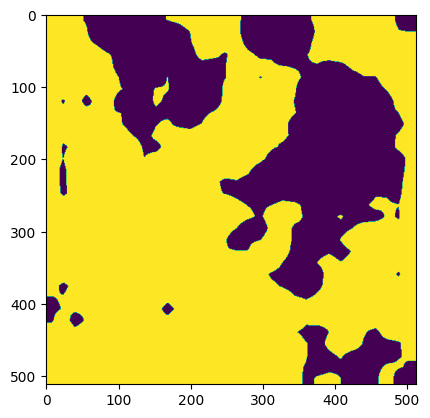

In [50]:
import matplotlib.pyplot as plt

plt.imshow(output_logits < 0.6)

In [48]:
output_logits

array([[0.58695652, 0.58695652, 0.58695652, ..., 0.65217391, 0.65217391,
        0.65217391],
       [0.58695652, 0.58695652, 0.58695652, ..., 0.65217391, 0.65217391,
        0.65217391],
       [0.58695652, 0.58695652, 0.58695652, ..., 0.65217391, 0.65217391,
        0.65217391],
       ...,
       [0.41304348, 0.41304348, 0.41304348, ..., 0.73913043, 0.73913043,
        0.73913043],
       [0.41304348, 0.41304348, 0.41304348, ..., 0.73913043, 0.73913043,
        0.73913043],
       [0.41304348, 0.41304348, 0.41304348, ..., 0.73913043, 0.73913043,
        0.73913043]])

In [22]:
plt.imshow(output_logits[:, :, 3] > 0.4)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plt.imshow(output_logits[:, :, 3] > 0.4)                                                     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [67]:
output_logits[:, :, 3].mean()

1.0